# The Credit Card Fraud Dataset - Synthesizing the Minority Class

In this notebook a practical exercise is presented to showcase the usage of the YData Synthetic library along with
GANs to synthesize tabular data.
For the purpose of this exercise, dataset of credit card fraud from Kaggle is used, that can be found here:
https://www.kaggle.com/mlg-ulb/creditcardfraud

## 1. Setup the library

### 1.1 Install `ydata-synthetic`

In [31]:
# Install ydata-synthetic lib
# ! pip install ydata-synthetic

### 1.2 Import libraries and GAN module

In [1]:
import importlib
import os
import sys  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.preprocessing.regular.credit_fraud import *

model = WGAN_GP

## 2. Read the dataset

In [2]:
# Read the original data and have it preprocessed
data = pd.read_csv('./data/creditcard.csv', index_col=[0])

In [3]:
# Extract list of columns
data_cols = list(data.columns)
print('Dataset columns: {}'.format(data_cols))

Dataset columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [4]:
# For the purpose of this example we will only synthesize the minority class
# train_data contains 492 rows which had 'Class' value as 1 (which were very few)
train_data = data.loc[ data['Class']==1 ].copy()

# Before training the GAN do not forget to apply the required data transformations
# To ease here we've applied a PowerTransformation - make data distribution more Gaussian-like.
data = transformations(train_data)

print("Dataset info: Number of records - {} Number of variables - {}".format(train_data.shape[0], train_data.shape[1]))

Dataset info: Number of records - 492 Number of variables - 30


## 3. GAN Training

### 3.1 Parameters Settings

In [19]:
# Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 20
epochs = 60+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9

train_sample = train_data.copy().reset_index(drop=True)

# All columns except 'Class'
data_cols = [ i for i in train_sample.columns if i not in "Class" ]

# Scale down the data
# train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

### 3.2 Training

In [20]:
# Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args, n_critic=5)
synthesizer.train(train_sample, train_args)

100%|██████████| 61/61 [00:05<00:00, 10.69it/s]


Iteration: 0 | disc_loss: 4.6622538566589355 | gen_loss: 0.005218371748924255
Iteration: 1 | disc_loss: 1.3074162006378174 | gen_loss: 0.013551609590649605
Iteration: 2 | disc_loss: 0.6269301176071167 | gen_loss: 0.023777998983860016
Iteration: 3 | disc_loss: 0.19706498086452484 | gen_loss: 0.032609723508358
Iteration: 4 | disc_loss: -0.024599626660346985 | gen_loss: 0.042243197560310364
Iteration: 5 | disc_loss: -0.0650465339422226 | gen_loss: 0.053455669432878494
Iteration: 6 | disc_loss: -0.14572001993656158 | gen_loss: 0.0624692440032959
Iteration: 7 | disc_loss: -0.16113775968551636 | gen_loss: 0.06976084411144257
Iteration: 8 | disc_loss: -0.18308374285697937 | gen_loss: 0.07603296637535095
Iteration: 9 | disc_loss: -0.21435384452342987 | gen_loss: 0.07383286952972412
Iteration: 10 | disc_loss: -0.24511943757534027 | gen_loss: 0.07256060838699341
Iteration: 11 | disc_loss: -0.24364808201789856 | gen_loss: 0.07035761326551437
Iteration: 12 | disc_loss: -0.2375497668981552 | gen_lo

### 3.3 Generator Summary

In [16]:
# Generator description
synthesizer.generator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense_16 (Dense)             (128, 128)                4224      
_________________________________________________________________
dense_17 (Dense)             (128, 256)                33024     
_________________________________________________________________
dense_18 (Dense)             (128, 512)                131584    
_________________________________________________________________
dense_19 (Dense)             (128, 30)                 15390     
Total params: 184,222
Trainable params: 184,222
Non-trainable params: 0
_________________________________________________________________


### 3.4 Discriminator Summary

In [ ]:
# Discriminator description
synthesizer.discriminator.summary()

## 4. Save the Model to Disk

In [ ]:
# You can easily save the trained generator and loaded it afterwards
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

## 5. Plot Results

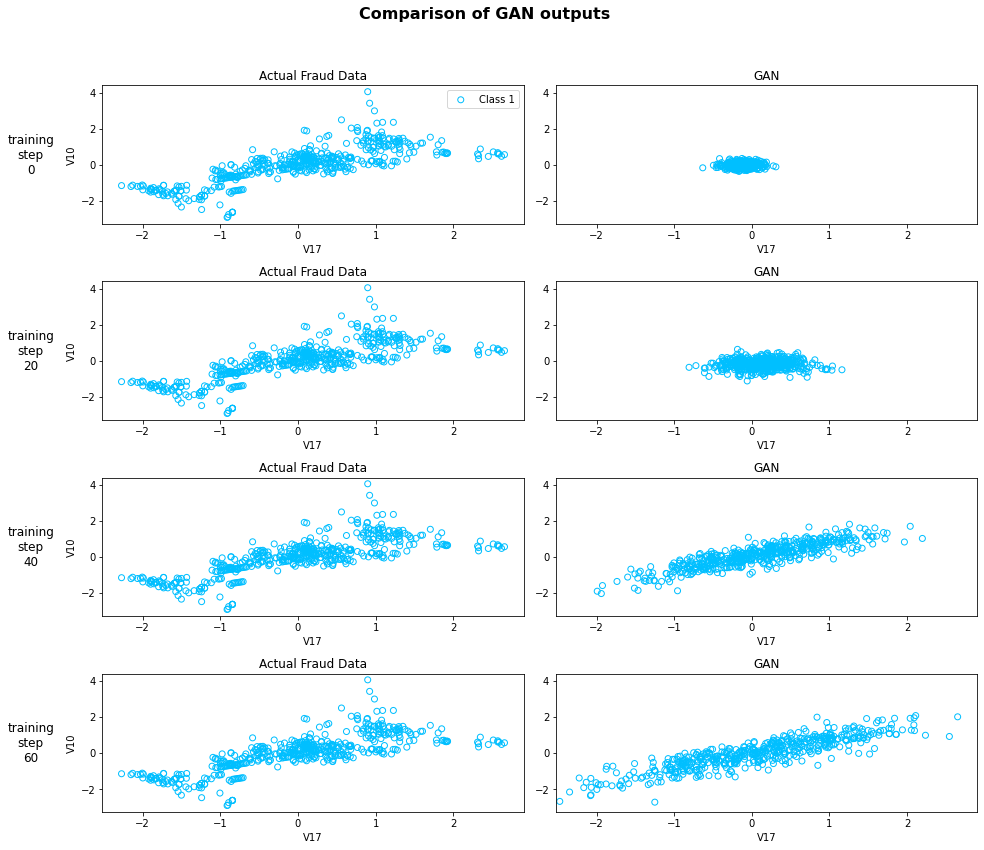

In [21]:
# Dictionary of our trained models
# Model -> [model_name, with_class, generator_model]
models = {'GAN': ['GAN', False, synthesizer.generator]}

# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
# real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
# real_samples = pd.DataFrame(real, columns=data_cols + ["Class"])
labels = train_sample['Class']

model_name = 'GAN'
colors = ['deepskyblue']
markers = 'o'
class_labels = 'Class 1'

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0,
20,
40,
60
 ]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)


    plt.scatter( train_sample[[col1]], train_sample[[col2]],
                         label=class_labels, marker=markers, edgecolors=colors, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    [model_name, with_class, generator_model] = models[model_name]
    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')
    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + 1 )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
    gen_samples.to_csv('./data/Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                     label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title(model_name)
    plt.xlabel(col1)
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)